In [1]:
from metattack import utils
from metattack import meta_gradient_attack as mtk
import numpy as np
import tensorflow as tf
import seaborn as sns
from matplotlib import pyplot as plt
import scipy.sparse as sp
try:
    from tqdm import tqdm
except ImportError:
    tqdm = lambda x: x

gpu_id = 0

In [2]:
_A_obs, _X_obs, _z_obs = utils.load_npz('data/citeseer.npz')
_A_obs = _A_obs + _A_obs.T
_A_obs[_A_obs > 1] = 1
lcc = utils.largest_connected_components(_A_obs)

_A_obs = _A_obs[lcc][:,lcc]
_A_obs.setdiag(0)
_A_obs = _A_obs.astype("float32")
_A_obs.eliminate_zeros()
_X_obs = _X_obs.astype("float32")

assert np.abs(_A_obs - _A_obs.T).sum() == 0, "Input graph is not symmetric"
assert _A_obs.max() == 1 and len(np.unique(_A_obs[_A_obs.nonzero()].A1)) == 1, "Graph must be unweighted"
assert _A_obs.sum(0).A1.min() > 0, "Graph contains singleton nodes"

_X_obs = _X_obs[lcc]
_z_obs = _z_obs[lcc]
_N = _A_obs.shape[0]
_K = _z_obs.max()+1
_Z_obs = np.eye(_K)[_z_obs]
_An = utils.preprocess_graph(_A_obs)
sizes = [16, _K]
degrees = _A_obs.sum(0).A1

seed = 15
unlabeled_share = 0.8
val_share = 0.1
train_share = 1 - unlabeled_share - val_share
np.random.seed(seed)

split_train, split_val, split_unlabeled = utils.train_val_test_split_tabular(np.arange(_N),
                                                                       train_size=train_share,
                                                                       val_size=val_share,
                                                                       test_size=unlabeled_share,
                                                                       stratify=_z_obs)
split_unlabeled = np.union1d(split_val, split_unlabeled)

Selecting 1 largest connected components


/nfs/staff-ssd/zuegnerd/miniconda3/envs/tf/lib/python3.6/site-packages/scipy/sparse/compressed.py:774: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


In [3]:
hidden_sizes = [16]
share_perturbations = 0.05
perturbations = int(share_perturbations * (_A_obs.sum()//2))
train_iters = 100
dtype = tf.float32 # change this to tf.float16 if you run out of GPU memory. Might affect the performance and lead to numerical instability

In [4]:
surrogate = mtk.GCNSparse(_A_obs, _X_obs, _Z_obs, hidden_sizes, gpu_id=gpu_id)
surrogate.build(with_relu=False)
surrogate.train(split_train)

Training: 100%|██████████| 200/200 [00:00<00:00, 270.63it/s]


In [5]:
# Predict the labels of the unlabeled nodes to use them for self-training.
labels_self_training = np.eye(_K)[surrogate.logits.eval(session=surrogate.session).argmax(1)]
labels_self_training[split_train] = _Z_obs[split_train]

In [6]:
# The attack variants from the paper
variants = ["Meta-Train", "Meta-Self","A-Meta-Train", "A-Meta-Self", "A-Meta-Both"]
# Choose the variant you would like to try
variant = "Meta-Self"
assert variant in variants

enforce_ll_constrant = False
approximate_meta_gradient = False
if variant.startswith("A-"): # approximate meta gradient
    approximate_meta_gradient = True
    if "Train" in variant:
        lambda_ = 1
    elif "Self" in variant:
        lambda_ = 0
    else:
        lambda_ = 0.5
        
if "Train" in variant:
    idx_attack = split_train
elif "Self" in variant:
    idx_attack = split_unlabeled
else:  # Both
    idx_attack = np.union1d(split_train, split_unlabeled)

In [7]:
if approximate_meta_gradient:
    gcn_attack = mtk.GNNMetaApprox(_A_obs, _X_obs, labels_self_training, hidden_sizes, 
                                   gpu_id=gpu_id, _lambda=lambda_, train_iters=train_iters, dtype=dtype)
else:
    gcn_attack = mtk.GNNMeta(_A_obs, _X_obs.toarray().astype("float32"), labels_self_training, hidden_sizes, 
                             gpu_id=gpu_id, attack_features=False, train_iters=train_iters, dtype=dtype)

In [8]:
gcn_attack.build()
gcn_attack.make_loss(ll_constraint=enforce_ll_constrant)

Unrolling training procedure: 100%|██████████| 100/100 [00:14<00:00,  7.20it/s]


In [9]:
if approximate_meta_gradient:
    gcn_attack.attack(perturbations, split_train, split_unlabeled, idx_attack)
else:
    gcn_attack.attack(perturbations, split_train, idx_attack)

Perturbing graph: 100%|██████████| 183/183 [02:49<00:00,  1.20it/s]


In [10]:
adjacency_changes = gcn_attack.adjacency_changes.eval(session=gcn_attack.session).reshape(_A_obs.shape)
modified_adjacency = gcn_attack.modified_adjacency.eval(session=gcn_attack.session)

In [11]:
re_trainings = 20

In [12]:
gcn_before_attack = mtk.GCNSparse(sp.csr_matrix(_A_obs), _X_obs, _Z_obs, hidden_sizes, gpu_id=gpu_id)
gcn_before_attack.build(with_relu=True)

In [13]:
accuracies_clean = []
for _it in tqdm(range(re_trainings)):
    gcn_before_attack.train(split_train, initialize=True, display=False)
    accuracy_clean = (gcn_before_attack.logits.eval(session=gcn_before_attack.session).argmax(1) == _z_obs)[split_unlabeled].mean()
    accuracies_clean.append(accuracy_clean)

100%|██████████| 20/20 [00:07<00:00,  2.84it/s]


In [14]:
gcn_after_attack = mtk.GCNSparse(sp.csr_matrix(modified_adjacency), _X_obs, _Z_obs, hidden_sizes, gpu_id=gpu_id)
gcn_after_attack.build(with_relu=True)

In [15]:
accuracies_atk = []
for _it in tqdm(range(re_trainings)):
    gcn_after_attack.train(split_train, initialize=True, display=False)
    accuracy_atk = (gcn_after_attack.logits.eval(session=gcn_after_attack.session).argmax(1) == _z_obs)[split_unlabeled].mean()
    accuracies_atk.append(accuracy_atk)

100%|██████████| 20/20 [00:08<00:00,  2.44it/s]


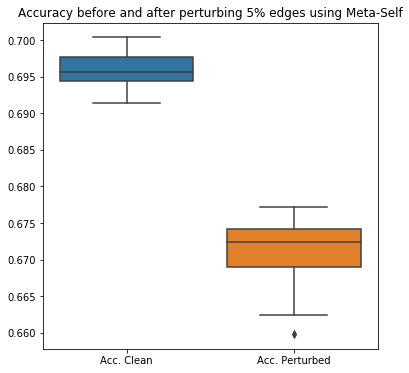

In [35]:
plt.figure(figsize=(6,6))
sns.boxplot(x=["Acc. Clean", "Acc. Perturbed"], y=[accuracies_clean, accuracies_atk])#, re_trainings*[accuracy_logistic]])
plt.title(f"Accuracy before and after perturbing {int(share_perturbations*100)}% edges using {variant}")
plt.savefig("example.png", dpi=600)
plt.savefig("example.svg")
plt.show()